##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Segmentação de Imagem

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Ver em TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Executar no Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    Ver código fonte no GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt-br/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Baixar notebook</a>
  </td>
</table>

Este tutorial concentra-se na tarefa de segmentação de imagens, usando uma <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external"> U-Net modificada </a>

## O que é segmentação de imagem?
Até agora, você viu a classificação de imagens, em que a tarefa da rede é atribuir um rótulo ou classe a uma imagem de entrada. No entanto, suponha que você queira saber onde um objeto está localizado na imagem, a forma desse objeto, qual pixel pertence a qual objeto etc. Nesse caso, você desejará segmentar a imagem, ou seja, para cada pixel da imagem é dado um rótulo. Assim, a tarefa da segmentação de imagens é treinar uma rede neural para produzir uma máscara da imagem em pixels. Isso ajuda a entender a imagem em um nível muito mais baixo, isto é, o nível de pixel. A segmentação de imagens tem muitas aplicações em imagens médicas, carros autônomos e imagens de satélite, para citar alguns.

O conjunto de dados que será usado para este tutorial é o [Oxford-IIIT Pet Dataset] (https://www.robots.ox.ac.uk/~vgg/data/pets/), criado por Parkhi *et al*. O conjunto de dados consiste em imagens, seus rótulos correspondentes e máscaras de pixel. As máscaras são basicamente etiquetas para cada pixel. Cada pixel recebe uma das três categorias:

* Classe 1: Pixel pertencente ao animal de estimação.
* Classe 2: Pixel na fronteira do animal de estimação.
* Classe 3: Nenhuma das opções acima/ Pixel circundante.

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Baixar o conjunto de dados Oxford-IIIT Pets

O conjunto de dados já está incluído nos conjuntos de dados TensorFlow, basta fazer o download. As máscaras de segmentação estão incluídas na versão 3+.

In [5]:
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
builder = tfds.builder('oxford_iiit_pet:3.*.*')
info = builder.info
print(info)
# by setting register_checksums as True to pass the check
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.0.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    urls=['http://www.robots.ox.ac.uk/~vgg/data/pets/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
      title        = "Cats and Dogs",
      booktitle    =

O código a seguir executa um aumento simples de inversão de uma imagem. Além disso, a imagem é normalizada para [0,1]. Finalmente, como mencionado acima, os pixels na máscara de segmentação são rotulados como {1,2,3}. Por uma questão de conveniência, vamos subtrair 1 da máscara de segmentação, resultando em rótulos que são: {0,1,2}.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

O conjunto de dados já contém as divisões necessárias de teste e treinamento e, portanto, vamos continuar usando a mesma divisão.

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Vamos dar uma olhada em um exemplo de imagem e sua máscara correspondente no conjunto de dados.

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

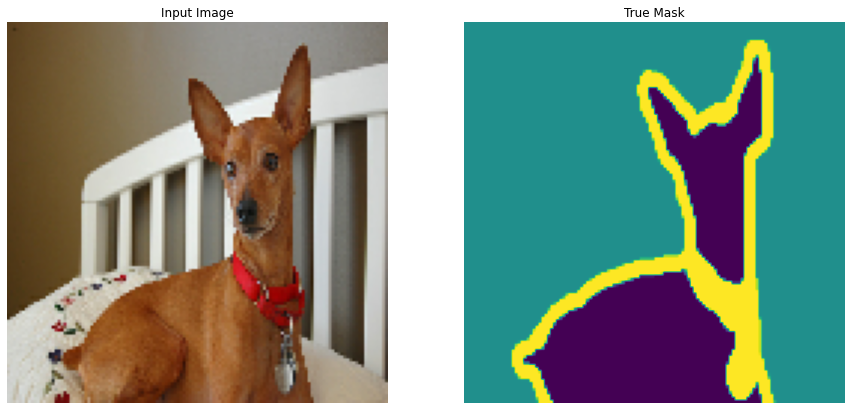

In [13]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Definir o modelo
O modelo usado aqui é uma U-Net modificada. Um U-Net consiste em um codificador (downsampler) e decodificador (upsampler). Para aprender características robustas e reduzir o número de parâmetros treináveis, um modelo pré-treinado pode ser usado como codificador. Portanto, o codificador para esta tarefa será um modelo MobileNetV2 pré-treinado, cujas saídas intermediárias serão usadas e o decodificador será o bloco de amostra superior já implementado no TensorFlow Examples no [tutorial Pix2pix] (https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

O motivo da saída de três canais é porque existem três rótulos possíveis para cada pixel. Pense nisso como multi-classificação, onde cada pixel está sendo classificado em três classes.

In [14]:
OUTPUT_CHANNELS = 3

Como mencionado, o codificador será um modelo MobileNetV2 pré-treinado, preparado e pronto para uso em [tf.keras.applications] (https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). O codificador consiste em saídas específicas de camadas intermediárias no modelo. Observe que o codificador não será treinado durante o processo de treinamento.

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

O decodificador/upsampler é simplesmente uma série de blocos de upsample implementados nos exemplos do TensorFlow.

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Treine o modelo
Agora, tudo o que resta a fazer é compilar e treinar o modelo. A perda que está sendo usada aqui é loss.sparse_categorical_crossentropy. O motivo para usar essa função de perda é porque a rede está tentando atribuir a cada pixel um rótulo, assim como a previsão de várias classes. Na verdadeira máscara de segmentação, cada pixel tem um {0,1,2}. A rede aqui está emitindo três canais. Essencialmente, cada canal está tentando aprender a prever uma classe, e loss.sparse_categorical_crossentropy é a perda recomendada para esse cenário. Usando a saída da rede, o rótulo atribuído ao pixel é o canal com o valor mais alto. É isso que a função create_mask está fazendo.

In [18]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Dê uma olhada rápida na arquitetura do modelo resultante:

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Vamos experimentar o modelo para ver o que ele prevê antes do treinamento.

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

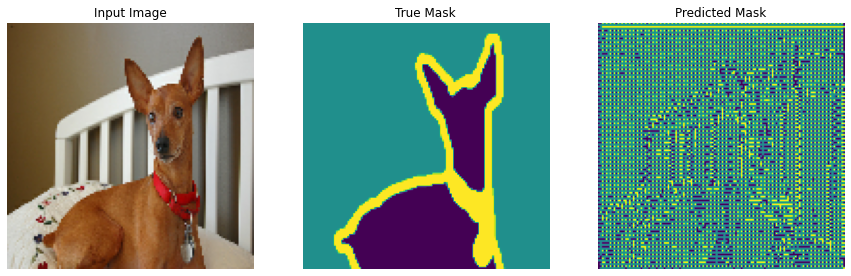

In [22]:
show_predictions()

Vamos observar como o modelo melhora enquanto está treinando. Para realizar essa tarefa, uma função de retorno de chamada é definida abaixo.

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

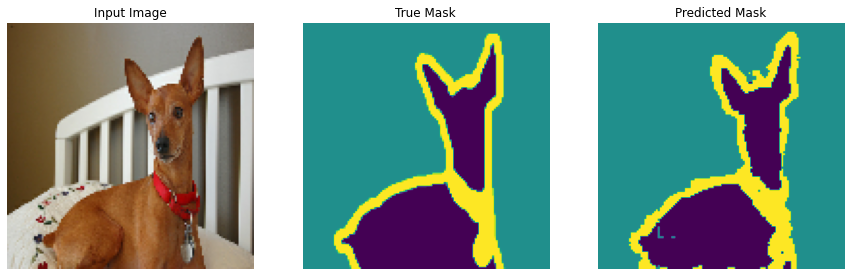


Sample Prediction after epoch 20



In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Fazer Previsões

Vamos fazer algumas previsões. Com o objetivo de economizar tempo, o número de épocas foi pequeno, mas você pode definir isso mais alto para obter resultados mais precisos.

In [ ]:
show_predictions(test_dataset, 3)

## Próximos passos
Agora que você entende o que é segmentação de imagem e como ela funciona, você pode tentar este tutorial com diferentes saídas de camada intermediária ou até mesmo modelo pré-treinado diferente. Você também pode se desafiar ao experimentar o desafio de mascaramento de imagem [Carvana] (https://www.kaggle.com/c/carvana-image-masking-challenge/overview) hospedado no Kaggle.

Você também pode querer ver a [API de detecção de objetos do Tensorflow] (https://github.com/tensorflow/models/tree/master/research/object_detection) para outro modelo que você pode treinar novamente com seus próprios dados.